In [33]:
from sklearn import model_selection, linear_model, metrics
from sklearn import preprocessing
from sklearn import pipeline
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [39]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Регрессия

Задача на kaggle: https://www.kaggle.com/c/bike-sharing-demand

По историческим данным о прокате велосипедов и погодным условиям необходимо оценить спрос на прокат велосипедов.

In [2]:
raw_data = pd.read_csv('../data/bike_sharing_demand.csv', header = 0, sep = ',')
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


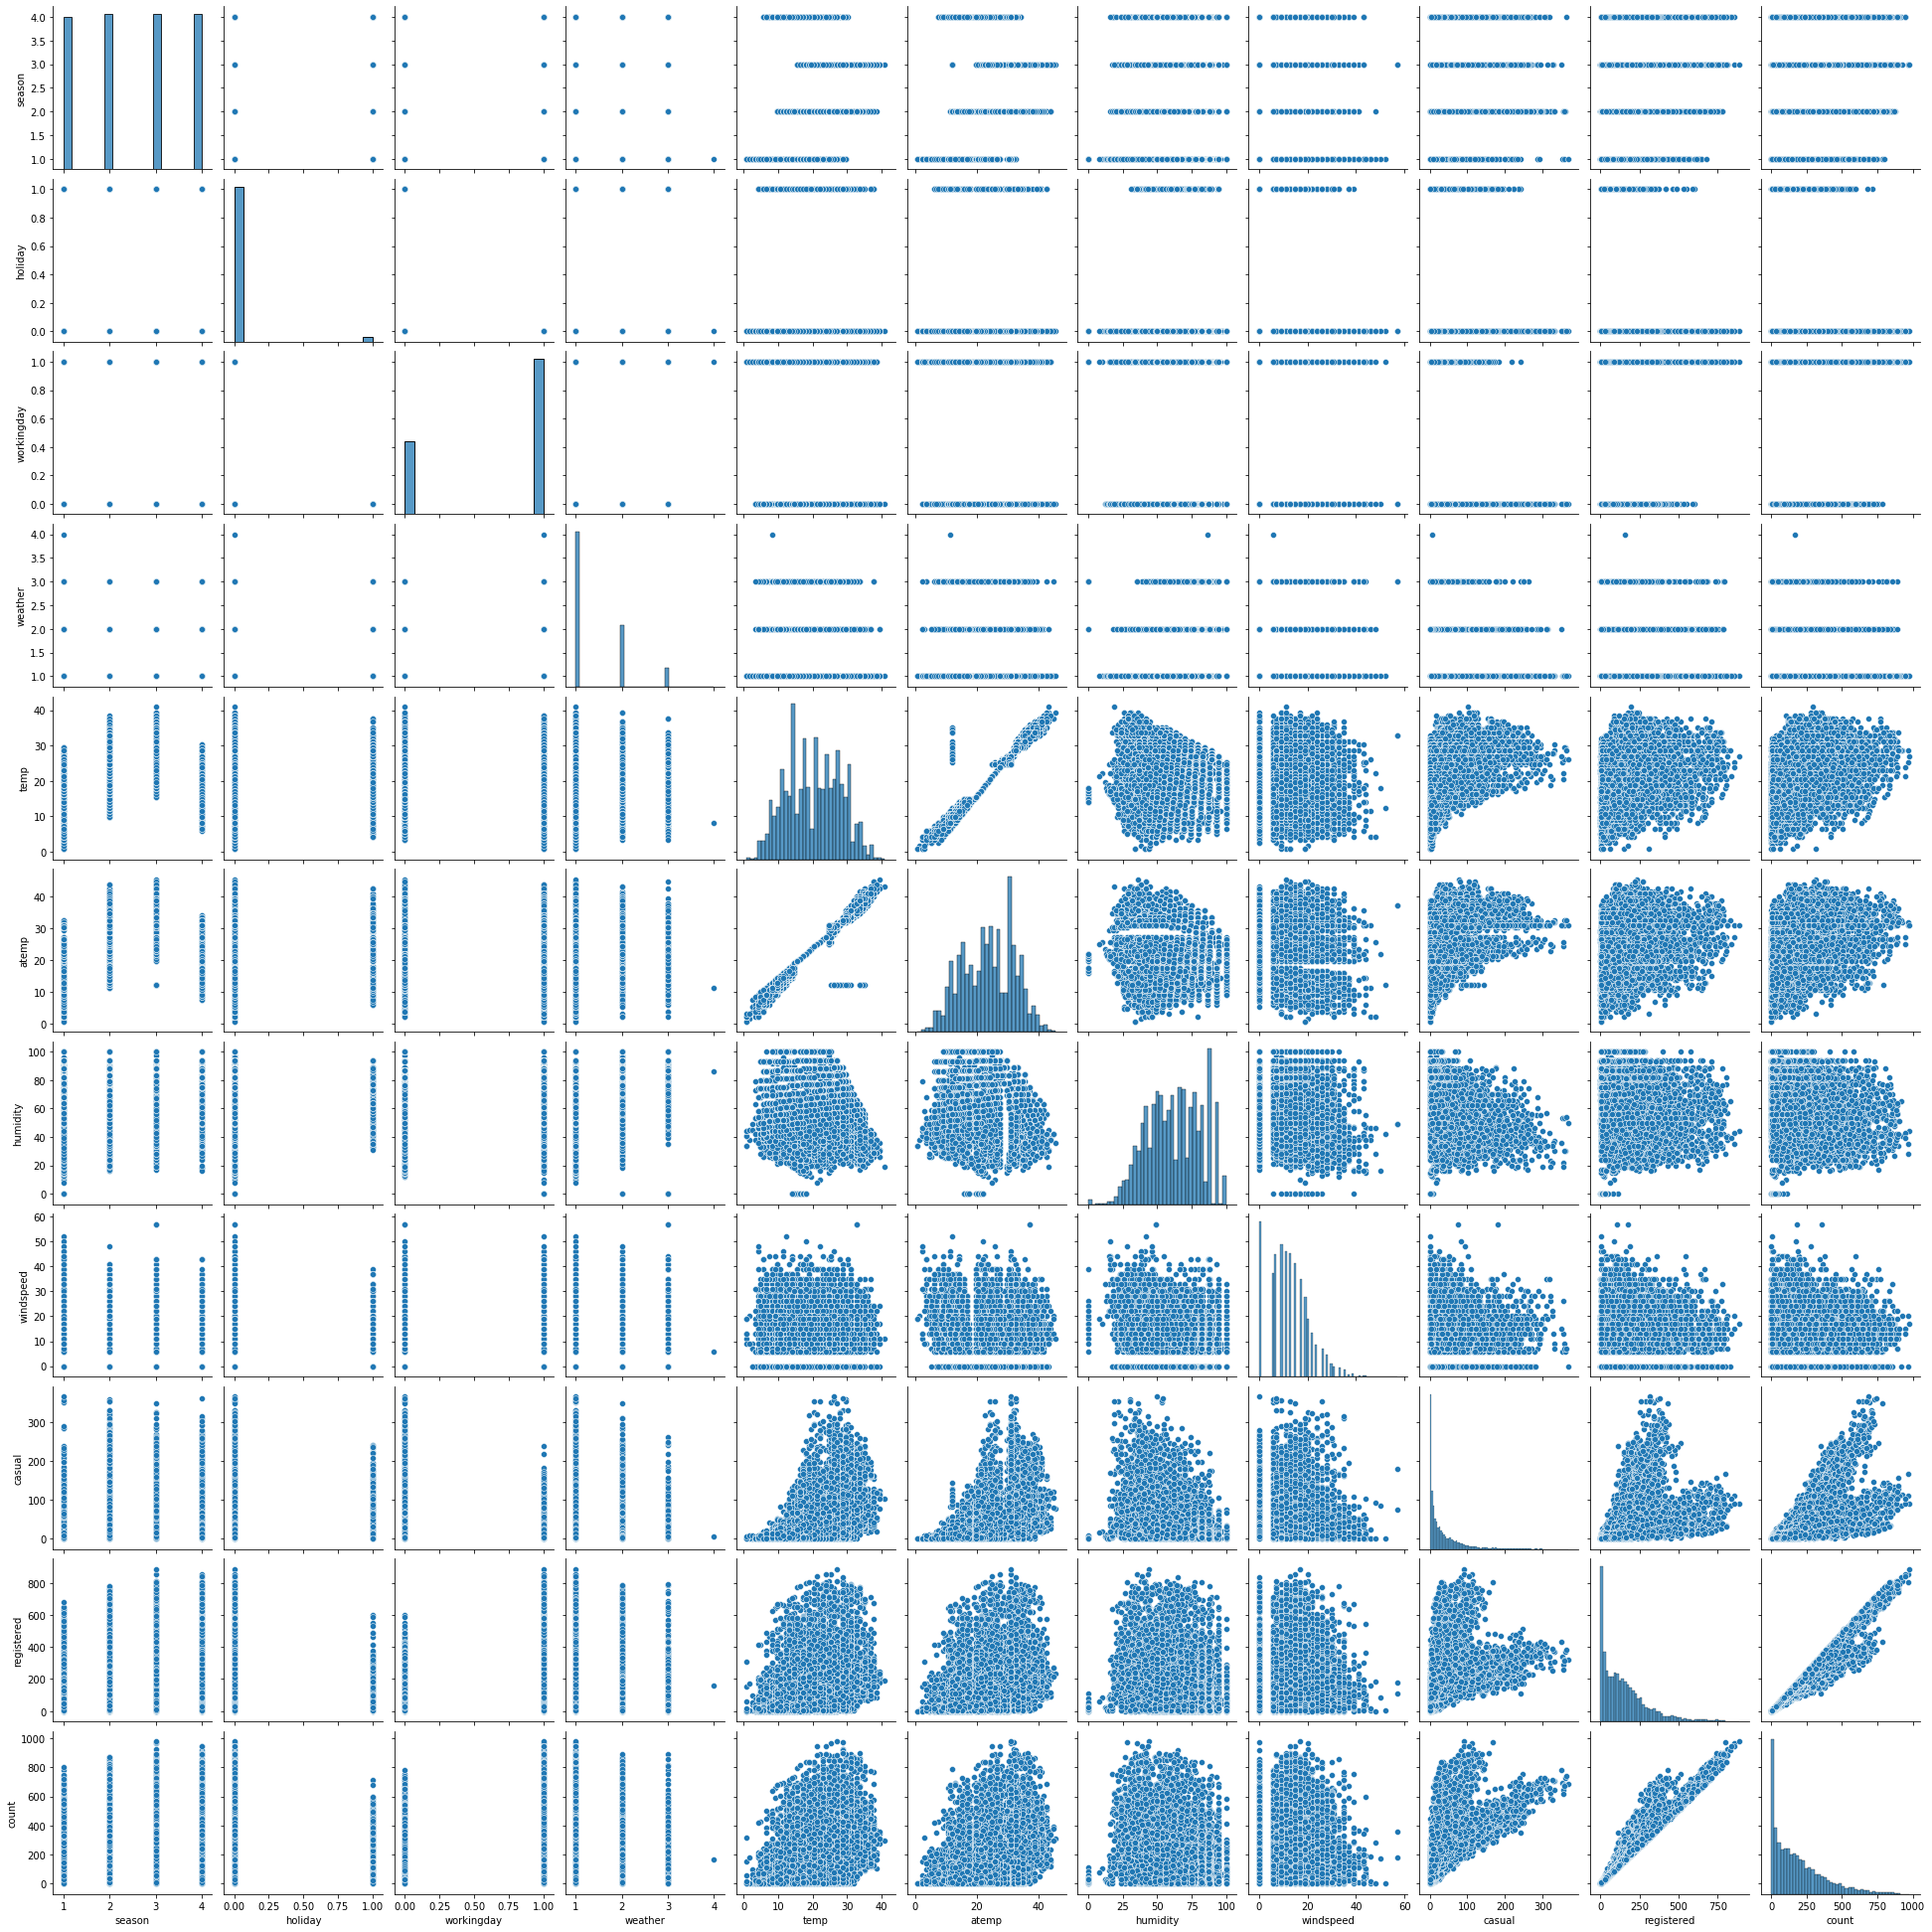

In [3]:
sns.pairplot(raw_data)

Предскажем кол-во велосипедов с помощью линейной регрессии

## Препроцессинг

In [4]:
raw_data.isnull().values.any()

False

In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [6]:
raw_data.datetime = raw_data.datetime.apply(pd.to_datetime)

Вместо Datetime сделаем два признака month и hour

In [7]:
raw_data['month'] = raw_data.datetime.apply(lambda x : x.month)
raw_data['hour'] = raw_data.datetime.apply(lambda x : x.hour)

raw_data = raw_data.drop(['datetime'], axis = 1)

In [8]:
raw_data.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,hour
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,2
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1,3
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,4


Признаки casual и registered - кол-во незарегестрированных и зарегестрированных пользователей, что в сумме дает целевую метку - кол-во всех пользователей, взявших велосипед на прокат

In [9]:
np.all(raw_data.registered + raw_data.casual == raw_data['count'])

True

Удалим эти признаки

In [10]:
raw_data.drop(['casual', 'registered'], axis = 1, inplace = True)

Сформируем выборки

In [11]:
#обучающая выборка
train_labels = raw_data.iloc[:-1000, :]['count'].values
train_data = raw_data.iloc[:-1000, :].drop(['count'], axis = 1)

#тестовая выборка
test_labels = raw_data.iloc[-1000:, :]['count'].values
test_data = raw_data.iloc[-1000:, :].drop(['count'], axis = 1)

In [12]:
print(raw_data.shape, train_data.shape, test_data.shape)

(10886, 11) (9886, 10) (1000, 10)


In [13]:
print(train_labels.shape, test_labels.shape)

(9886,) (1000,)


## Обучение

In [15]:
#создаем стандартный scaler
scaler = preprocessing.StandardScaler()

#модель - стохастический градиентный спуск
regressor = linear_model.SGDRegressor(random_state = 0)

#создаем pipeline из двух шагов: scaling и регрессия
pipeline = pipeline.Pipeline(steps = [('scaling', scaler), ('regression', regressor)])

In [16]:
pipeline.fit(train_data, train_labels)
metrics.mean_absolute_error(test_labels, pipeline.predict(test_data))

121.83793258867532

### Подбор параметров

Подберем оптимальные параметры с помощью кросс валидации

In [17]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaling', 'regression', 'scaling__copy', 'scaling__with_mean', 'scaling__with_std', 'regression__alpha', 'regression__average', 'regression__early_stopping', 'regression__epsilon', 'regression__eta0', 'regression__fit_intercept', 'regression__l1_ratio', 'regression__learning_rate', 'regression__loss', 'regression__max_iter', 'regression__n_iter_no_change', 'regression__penalty', 'regression__power_t', 'regression__random_state', 'regression__shuffle', 'regression__tol', 'regression__validation_fraction', 'regression__verbose', 'regression__warm_start'])

In [18]:
parameters_grid = {
    'regression__loss' : ['huber', 'epsilon_insensitive', 'squared_loss', ],
    'regression__max_iter' : [3, 5, 10, 50], 
    'regression__penalty' : ['l1', 'l2', 'none'],
    'regression__alpha' : [0.0001, 0.01],
    'scaling__with_mean' : [0., 0.5],
}

In [19]:
grid_cv = model_selection.GridSearchCV(pipeline, parameters_grid, scoring = 'neg_mean_absolute_error', cv = 4)

In [20]:
grid_cv.fit(train_data, train_labels)

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaling',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('regression',
                                        SGDRegressor(alpha=0.0001,
                                                     average=False,
                                                     early_stopping=False,
                                                     epsilon=0.1, eta0=0.01,
                                                     fit_intercept=True,
                                                     l1_ratio=0.15,
                                                     learning_rate='invscaling',
                                                     loss='squared_loss',
      

In [21]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-108.50546872459662
{'regression__alpha': 0.01, 'regression__loss': 'squared_loss', 'regression__max_iter': 3, 'regression__penalty': 'l2', 'scaling__with_mean': 0.0}


## Оценка модели

In [22]:
metrics.mean_absolute_error(test_labels, grid_cv.best_estimator_.predict(test_data))

121.64188924277826

Видим, что линейная регрессия на этих данных работает плохо, подбор параметров не помог. Возможно стоит попробовать другую модель, например случайный лес.

## Другая модель

Сравним линейную модель, например, со случайным лесом, и посмотрим качество

In [23]:
from sklearn.ensemble import RandomForestRegressor

In [24]:
regressor = RandomForestRegressor(random_state = 0, max_depth = 20, n_estimators = 50)

In [35]:
estimator = pipeline.Pipeline(steps = [('model_fitting', regressor)])

In [36]:
estimator.fit(train_data, train_labels)
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

78.2182763404125

Ошибка стала намного меньше

In [37]:
test_labels[:10]

array([525, 835, 355, 222, 228, 325, 328, 308, 346, 446], dtype=int64)

In [38]:
estimator.predict(test_data)[:10]

array([357.664     , 542.5       , 251.796     , 168.57055411,
       213.75060173, 249.78324871, 245.26830751, 319.34199227,
       277.03433684, 424.98333333])

Text(0.5, 1.0, 'random forest model')

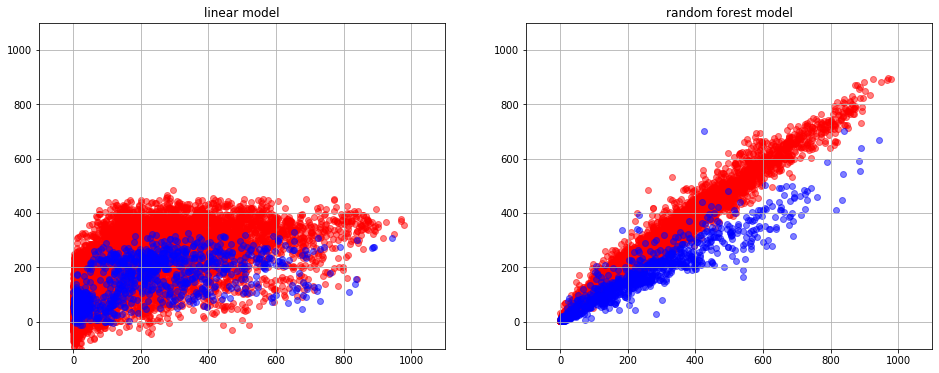

In [40]:
pylab.figure(figsize=(16, 6))

pylab.subplot(1,2,1)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('linear model')

pylab.subplot(1,2,2)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, estimator.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, estimator.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('random forest model')

Видим, что предсказания лежат близко к диагональной области.Зависимость удалось восстановить лучше